# Model training lab

This is the notebook for loading and training models.
Furthermore it provides simple documentation for different approaches used for training a model.

Run the command below to see command-completion on pressing `TAB`.

## Prerequisits

In [1]:
# Imports
import os
import warnings
import tools
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import Bidirectional
from matplotlib import pyplot



# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Root CSV files directory
dirname = "./data/"  

# Constant frame count.
frames = 100


#Preparation Stage - Load data and normalize
listfile = os.listdir(dirname)
data = []
for wordname in listfile:
    if wordname == ".DS_Store":
        continue
    for csv in os.listdir(dirname + wordname):
        filepath = os.path.join(dirname, wordname, csv)
        content = pd.read_csv(filepath, sep=';')
        content = content.reindex(list(range(0, frames)), fill_value=0.5)
        content.fillna(0.5, inplace = True) 
        data.append((wordname, content))
        
#Split data 60-20-20

features = [n[1] for n in data]
features = [f.to_numpy() for f in features]
labels = [n[0] for n in data]
x_train, x_val, y_train, y_val = train_test_split(features, labels, test_size=0.40, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.50, random_state=42)

#Enumerate
def printCountDataSets(dataset):
    wortCounter = []
    #Liste mit einmaligen Labels erstellen
    labels = sorted(set(dataset), key=dataset.index)
    #Liste nochmal Alphabetisch sortieren
    labels = sorted(labels)
    for label in labels:
        wortCounter.append(0)
    for row in dataset:
        for i in range(len(labels)):
            if str(labels[i]).startswith(row):
                wortCounter[i] += 1
    for i in range(len(labels)):
        print(labels[i], ': ', wortCounter[i], end =";  ")
    print(' ')        
    
print('Amount Datasets by word total:')
printCountDataSets(labels)
print('')

print('Amount Datasets by word training:')
printCountDataSets(y_train)
print('')

print('Amount Datasets by word validiation:')
printCountDataSets(y_val)
print('')

print('Amount Datasets by word test:')
printCountDataSets(y_test)
print('')


# Display data distribution
print('Distribution of data:')
print("Amount total:", len(labels))
print("Amount training:", len(y_train))
print("Amount validiation:", len(y_val))
print("Amount test:", len(y_test))
print('')

#Tokenize (One Hot)
tokenizer = tools.tokenize(dirname)
print('Tokens:')
print(tokenizer.word_index)
print('')
with open('tokens_json.txt', 'w') as outfile:
    outfile.write(tokenizer.to_json())

encoded_train=tokenizer.texts_to_sequences([y_train])[0]
encoded_val=tokenizer.texts_to_sequences([y_val])[0]
encoded_test=tokenizer.texts_to_sequences([y_test])[0]

y_train = to_categorical(encoded_train)
y_val = to_categorical(encoded_val)
y_test = to_categorical(encoded_test)

print('Categories in OneHot anotation:')
print(y_train)
print('')
# Making numpy arrays
x_train=np.array(x_train)
y_train=np.array(y_train)
x_val=np.array(x_val)
y_val=np.array(y_val)
x_test=np.array(x_test)
y_test=np.array(y_test)

print('Dataset coordinate Values:')
print(x_train)
print('')

#import winsound
#def finished(num):
#    frequency = 2000  # Set Frequency To 2500 Hertz
#    duration = 500  # Set Duration To 1000 ms == 1 second
#    for i in range(0, num):
#        winsound.Beep(frequency, duration)
    

Amount Datasets by word total:
Computer :  57;  Deutschland :  65;  Haben :  68;  Hallo :  57;  Mainz :  65;  Software :  67;  Welt :  66;  du :  66;  ich :  66;  unser :  64;  zeigen :  69;   

Amount Datasets by word training:
Computer :  30;  Deutschland :  41;  Haben :  43;  Hallo :  42;  Mainz :  43;  Software :  38;  Welt :  41;  du :  35;  ich :  44;  unser :  32;  zeigen :  37;   

Amount Datasets by word validiation:
Computer :  9;  Deutschland :  13;  Haben :  13;  Hallo :  9;  Mainz :  13;  Software :  18;  Welt :  13;  du :  13;  ich :  11;  unser :  17;  zeigen :  13;   

Amount Datasets by word test:
Computer :  18;  Deutschland :  11;  Haben :  12;  Hallo :  6;  Mainz :  9;  Software :  11;  Welt :  12;  du :  18;  ich :  11;  unser :  15;  zeigen :  19;   

Distribution of data:
Amount total: 710
Amount training: 426
Amount validiation: 142
Amount test: 142

Tokens:
{'zeigen': 1, 'unser': 2, 'deutschland': 3, 'computer': 4, 'welt': 5, 'software': 6, 'du': 7, 'hallo': 8,

## Training Stage
Configure the model and train it.

Metrics:
<div float="right">
    <img src="assets/accuracy.png" width="400"> 
    <img src="assets/precision_recall_formula.png" width="400">
</div>
<img src="assets/precision_recall.png" width="1000">


### <span style="color:blue"> Hyperparametertuned LSTM </span>
##### Here it is necessary to install the Keras-Tuner Module by executing:
#####  <span style="color:green"> via Conda:</span>
conda install -c conda-forge keras-tuner
#####  <span style="color:green"> for pip:</span>
pip install keras-tuner

Right now there are three different builds we are testing:
- classic LSTM
- CuDNNLSTM
- bidriectional LSTM


In [5]:
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband
from kerastuner.engine.hyperparameters import HyperParameters
from time import time, strftime


starttime= strftime("%Y_%m_%d_%H%M%S")
LOG_DIR = "C:\ML\Optimization_"f"{starttime}" #<-In Windows below Log_dir Path will maybe be too long for Windows to handle, so use a shorter path like this here
#LOG_DIR = "./Optimization_"f"{starttime}" # LOG_DIR holds json files with information and a model of each single trial

def build_model_lstm(hp):
    model = Sequential()
    
    model.add(layers.LSTM(hp.Int("LSTM_input", min_value =64, max_value=256,step=64, default=64), #kerastuner will randomly choose a value for nodes between 128 and 256 in steps of 64
                            return_sequences=True,
                            input_shape=(x_train.shape[1], x_train.shape[2])))
    
    for i in range(hp.Int("n_layers" , 1, 3)):    #number of layers ramdom between 1 an 3
        model.add(layers.LSTM(hp.Int(f"LSTM_{i}_units", min_value =64, max_value=256,step=64, default=64),return_sequences=True))
    
    model.add(layers.LSTM(hp.Int(f"LSTM_End", min_value =32, max_value=128,step=32, default=32)))
    model.add(layers.Dense(12, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  #optimizer=hp.Choice('optimizer',values=['Adam','RMSprop','SGD']),
                  optimizer=hp.Choice('optimizer',values=['Adagrad','Adamax','Adam','RMSprop']),
                  metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    model.summary()
    print(model.optimizer.get_config()["name"])
    print('')
    return model



def build_model_CuDNNLSTM(hp):
    model = Sequential()
    

    
    model.add(tf.compat.v1.keras.layers.CuDNNLSTM(hp.Int("LSTM_input", min_value =64, max_value=256,step=64, default=64), #kerastuner will randomly choose a value for nodes between 128 and 256 in steps of 64
                            return_sequences=True,
                            input_shape=(x_train.shape[1], x_train.shape[2])))
    
    for i in range(hp.Int("n_layers" , 1, 3)):    #number of layers ramdom between 1 an 3
        model.add(tf.compat.v1.keras.layers.CuDNNLSTM(hp.Int(f"LSTM_{i}_units", min_value =64, max_value=256,step=64, default=64),return_sequences=True))
    
    model.add(tf.compat.v1.keras.layers.CuDNNLSTM(hp.Int(f"LSTM_End", min_value =32, max_value=128,step=32, default=32)))
    model.add(layers.Dense(12, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  #optimizer=hp.Choice('optimizer',values=['Adam','RMSprop','SGD']),
                  optimizer=hp.Choice('optimizer',values=['Adagrad','Adamax','Adam','RMSprop']),
                  metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    model.summary()
    print(model.optimizer.get_config()["name"])
    print('')
    return model



def build_model_bdlstm(hp):
    model = Sequential()
    model.add(Bidirectional(layers.LSTM(hp.Int("LSTM_input", min_value =64, max_value=256,step=64, default=64),
                                        return_sequences=True),
                                        input_shape=(100, 86)))
    
    for i in range(hp.Int("n_layers" , 1, 3)):    #number of layers ramdom between 1 an 3
        model.add(layers.Bidirectional(layers.LSTM(hp.Int(f"LSTM_{i}_units", min_value =64, max_value=256,step=64, default=64),return_sequences=True)))
    
    model.add(layers.Bidirectional(layers.LSTM(hp.Int(f"LSTM_End", min_value =32, max_value=128,step=32, default=32))))
    model.add(layers.Dense(12, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  #optimizer=hp.Choice('optimizer',values=['Adagrad','Adamax','Adam','RMSprop']),
                  optimizer=hp.Choice('optimizer',values=['Adamax']),
                  metrics=['accuracy']) 
    model.summary()
    print(model.optimizer.get_config()["name"])
    print('')
    return model






###   <span style="color:red">Necesarry only in case of using Nvidia GPU  </span>

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices)) 

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Num GPUs: 1


# Different Keras-Tuner Approaches
### 1 - RandomSearch
Parameter of variables are ranomly used (number of layers, number of nodes) and "best" model is chosen.

In [6]:
tuner  = RandomSearch(
    build_model_bdlstm,     #Function to use search in... See different builds above
    objective = "val_accuracy",  #Chooses "best model" looking for highest value of val_accuracy
    max_trials = 30,       # Number of different combinations tried Nodes and layers
    executions_per_trial = 1, 
    directory = LOG_DIR,
    project_name='SignLagnuageModelOptimization'
    )

#tuner.search_space_summary()

tuner.search(x=x_train,      #syntax just like in fit
                y= y_train,
            epochs=200,
            batch_size=32,
            validation_data=(x_val,y_val),
            verbose=2
            )

print(tuner.get_best_hyperparameters()[0].values)
print(tuner.results_summary())

finished(8)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100, 128)          77312     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 12)                780       
Total params: 218,124
Trainable params: 218,124
Non-trainable params: 0
_________________________________________________________________
Adamax

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100, 512)          702464    
______________________

Epoch 66/200
14/14 - 0s - loss: 0.0788 - accuracy: 0.9859 - val_loss: 0.8007 - val_accuracy: 0.7606
Epoch 67/200
14/14 - 0s - loss: 0.0733 - accuracy: 0.9930 - val_loss: 0.7195 - val_accuracy: 0.7676
Epoch 68/200
14/14 - 0s - loss: 0.0731 - accuracy: 0.9812 - val_loss: 0.7587 - val_accuracy: 0.7324
Epoch 69/200
14/14 - 1s - loss: 0.0517 - accuracy: 0.9977 - val_loss: 0.6766 - val_accuracy: 0.7887
Epoch 70/200
14/14 - 0s - loss: 0.0600 - accuracy: 0.9906 - val_loss: 0.7648 - val_accuracy: 0.7394
Epoch 71/200
14/14 - 0s - loss: 0.0653 - accuracy: 0.9906 - val_loss: 0.6992 - val_accuracy: 0.7887
Epoch 72/200
14/14 - 0s - loss: 0.0476 - accuracy: 0.9977 - val_loss: 0.7600 - val_accuracy: 0.7606
Epoch 73/200
14/14 - 0s - loss: 0.0540 - accuracy: 0.9953 - val_loss: 0.6878 - val_accuracy: 0.7817
Epoch 74/200
14/14 - 0s - loss: 0.0445 - accuracy: 1.0000 - val_loss: 0.7714 - val_accuracy: 0.7535
Epoch 75/200
14/14 - 0s - loss: 0.0375 - accuracy: 1.0000 - val_loss: 0.7179 - val_accuracy: 0.7535


Epoch 148/200
14/14 - 0s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.6001 - val_accuracy: 0.8310
Epoch 149/200
14/14 - 0s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.5995 - val_accuracy: 0.8310
Epoch 150/200
14/14 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.5996 - val_accuracy: 0.8380
Epoch 151/200
14/14 - 0s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.6014 - val_accuracy: 0.8380
Epoch 152/200
14/14 - 0s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.6001 - val_accuracy: 0.8310
Epoch 153/200
14/14 - 0s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.6007 - val_accuracy: 0.8380
Epoch 154/200
14/14 - 0s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.5922 - val_accuracy: 0.8380
Epoch 155/200
14/14 - 0s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.5989 - val_accuracy: 0.8380
Epoch 156/200
14/14 - 0s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.5938 - val_accuracy: 0.8310
Epoch 157/200
14/14 - 0s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.5959 - val_accurac

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100, 256)          220160    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          394240    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          164352    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 192)               172800    
_________________________________________________________________
dense (Dense)                (None, 12)                2316      
Total params: 953,868
Trainable params: 953,868
Non-trainable params: 0
_________________________________________________________________
Adamax

Epoch 1/200
14/14 - 2s - loss: 2.4584 - accuracy: 0.0939 - val_loss: 2.4133 - val_accuracy: 0.0915
Epoch 2/2

Epoch 73/200
14/14 - 0s - loss: 0.0838 - accuracy: 0.9859 - val_loss: 0.7460 - val_accuracy: 0.7887
Epoch 74/200
14/14 - 0s - loss: 0.0554 - accuracy: 0.9906 - val_loss: 0.8384 - val_accuracy: 0.7676
Epoch 75/200
14/14 - 0s - loss: 0.0438 - accuracy: 0.9953 - val_loss: 0.7029 - val_accuracy: 0.7817
Epoch 76/200
14/14 - 0s - loss: 0.0332 - accuracy: 0.9977 - val_loss: 0.6906 - val_accuracy: 0.8169
Epoch 77/200
14/14 - 1s - loss: 0.0271 - accuracy: 1.0000 - val_loss: 0.7459 - val_accuracy: 0.7887
Epoch 78/200
14/14 - 0s - loss: 0.0239 - accuracy: 1.0000 - val_loss: 0.6353 - val_accuracy: 0.8028
Epoch 79/200
14/14 - 0s - loss: 0.0211 - accuracy: 1.0000 - val_loss: 0.6752 - val_accuracy: 0.8169
Epoch 80/200
14/14 - 0s - loss: 0.0183 - accuracy: 1.0000 - val_loss: 0.6395 - val_accuracy: 0.8169
Epoch 81/200
14/14 - 0s - loss: 0.0165 - accuracy: 1.0000 - val_loss: 0.6211 - val_accuracy: 0.8239
Epoch 82/200
14/14 - 0s - loss: 0.0151 - accuracy: 1.0000 - val_loss: 0.6226 - val_accuracy: 0.8310


Epoch 155/200
14/14 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.6451 - val_accuracy: 0.8380
Epoch 156/200
14/14 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.6444 - val_accuracy: 0.8380
Epoch 157/200
14/14 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.6451 - val_accuracy: 0.8310
Epoch 158/200
14/14 - 0s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.6475 - val_accuracy: 0.8310
Epoch 159/200
14/14 - 0s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.6468 - val_accuracy: 0.8310
Epoch 160/200
14/14 - 0s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.6475 - val_accuracy: 0.8310
Epoch 161/200
14/14 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.6487 - val_accuracy: 0.8310
Epoch 162/200
14/14 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.6483 - val_accuracy: 0.8310
Epoch 163/200
14/14 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.6498 - val_accuracy: 0.8310
Epoch 164/200
14/14 - 0s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.6490 - val_accurac

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100, 384)          428544    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          525312    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 256)          394240    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 12)                1548      
Total params: 1,513,996
Trainable params: 1,513,996
Non-trainable params: 0
_________________________________________________________________
Adamax

Epoch 1/200
14/14 - 2s - loss: 2.4541 - accuracy: 0.1103 - val_loss: 2.4024 - val_accuracy: 0.1268
Epoch

Epoch 73/200
14/14 - 0s - loss: 0.0232 - accuracy: 1.0000 - val_loss: 0.7805 - val_accuracy: 0.7887
Epoch 74/200
14/14 - 1s - loss: 0.0225 - accuracy: 1.0000 - val_loss: 0.7912 - val_accuracy: 0.7817
Epoch 75/200
14/14 - 0s - loss: 0.0215 - accuracy: 1.0000 - val_loss: 0.7651 - val_accuracy: 0.7746
Epoch 76/200
14/14 - 0s - loss: 0.0206 - accuracy: 1.0000 - val_loss: 0.7835 - val_accuracy: 0.7887
Epoch 77/200
14/14 - 0s - loss: 0.0196 - accuracy: 1.0000 - val_loss: 0.7968 - val_accuracy: 0.7746
Epoch 78/200
14/14 - 0s - loss: 0.0189 - accuracy: 1.0000 - val_loss: 0.8002 - val_accuracy: 0.7958
Epoch 79/200
14/14 - 0s - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.7991 - val_accuracy: 0.7958
Epoch 80/200
14/14 - 0s - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0.7889 - val_accuracy: 0.7958
Epoch 81/200
14/14 - 0s - loss: 0.0166 - accuracy: 1.0000 - val_loss: 0.7999 - val_accuracy: 0.8028
Epoch 82/200
14/14 - 0s - loss: 0.0163 - accuracy: 1.0000 - val_loss: 0.7816 - val_accuracy: 0.7817


Epoch 155/200
14/14 - 0s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.8158 - val_accuracy: 0.8028
Epoch 156/200
14/14 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.8084 - val_accuracy: 0.8099
Epoch 157/200
14/14 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.8168 - val_accuracy: 0.8169
Epoch 158/200
14/14 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.8220 - val_accuracy: 0.8099
Epoch 159/200
14/14 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.8259 - val_accuracy: 0.7958
Epoch 160/200
14/14 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.8137 - val_accuracy: 0.8099
Epoch 161/200
14/14 - 1s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.8237 - val_accuracy: 0.8099
Epoch 162/200
14/14 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.7952 - val_accuracy: 0.8099
Epoch 163/200
14/14 - 0s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.8185 - val_accuracy: 0.8169
Epoch 164/200
14/14 - 0s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.8091 - val_accurac

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100, 384)          428544    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          525312    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 384)          689664    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 192)               369408    
_________________________________________________________________
dense (Dense)                (None, 12)                2316      
Total params: 2,015,244
Trainable params: 2,015,244
Non-trainable params: 0
_________________________________________________________________
Adamax

Epoch 1/200
14/14 - 2s - loss: 2.4796 - accuracy: 0.0610 - val_loss: 2.4357 - val_accuracy: 0.0704
Epoch

Epoch 73/200
14/14 - 1s - loss: 0.0269 - accuracy: 0.9953 - val_loss: 0.6740 - val_accuracy: 0.8099
Epoch 74/200
14/14 - 1s - loss: 0.0197 - accuracy: 1.0000 - val_loss: 0.6521 - val_accuracy: 0.8028
Epoch 75/200
14/14 - 1s - loss: 0.0170 - accuracy: 1.0000 - val_loss: 0.6669 - val_accuracy: 0.7958
Epoch 76/200
14/14 - 1s - loss: 0.0161 - accuracy: 1.0000 - val_loss: 0.6568 - val_accuracy: 0.7958
Epoch 77/200
14/14 - 1s - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.6488 - val_accuracy: 0.7958
Epoch 78/200
14/14 - 1s - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.6442 - val_accuracy: 0.7958
Epoch 79/200
14/14 - 1s - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.6480 - val_accuracy: 0.8099
Epoch 80/200
14/14 - 1s - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.6465 - val_accuracy: 0.7958
Epoch 81/200
14/14 - 1s - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.6421 - val_accuracy: 0.7958
Epoch 82/200
14/14 - 1s - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.6427 - val_accuracy: 0.7958


Epoch 155/200
14/14 - 1s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.6543 - val_accuracy: 0.8310
Epoch 156/200
14/14 - 1s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.6583 - val_accuracy: 0.8310
Epoch 157/200
14/14 - 1s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.6531 - val_accuracy: 0.8310
Epoch 158/200
14/14 - 1s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.6544 - val_accuracy: 0.8310
Epoch 159/200
14/14 - 1s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.6571 - val_accuracy: 0.8310
Epoch 160/200
14/14 - 1s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.6555 - val_accuracy: 0.8310
Epoch 161/200
14/14 - 1s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.6478 - val_accuracy: 0.8380
Epoch 162/200
14/14 - 1s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.6711 - val_accuracy: 0.8380
Epoch 163/200
14/14 - 1s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.6833 - val_accuracy: 0.8310
Epoch 164/200
14/14 - 1s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.6765 - val_accurac

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100, 256)          220160    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          394240    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          164352    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 12)                1548      
Total params: 879,116
Trainable params: 879,116
Non-trainable params: 0
_________________________________________________________________
Adamax

Epoch 1/200
14/14 - 2s - loss: 2.4690 - accuracy: 0.0869 - val_loss: 2.4013 - val_accuracy: 0.0915
Epoch 2/2

Epoch 73/200
14/14 - 0s - loss: 0.0448 - accuracy: 1.0000 - val_loss: 0.8443 - val_accuracy: 0.7817
Epoch 74/200
14/14 - 1s - loss: 0.0419 - accuracy: 0.9953 - val_loss: 0.7746 - val_accuracy: 0.7746
Epoch 75/200
14/14 - 0s - loss: 0.0435 - accuracy: 0.9977 - val_loss: 0.7995 - val_accuracy: 0.7817
Epoch 76/200
14/14 - 0s - loss: 0.0396 - accuracy: 0.9977 - val_loss: 0.8064 - val_accuracy: 0.7535
Epoch 77/200
14/14 - 0s - loss: 0.0525 - accuracy: 0.9930 - val_loss: 0.9941 - val_accuracy: 0.7324
Epoch 78/200
14/14 - 0s - loss: 0.0818 - accuracy: 0.9789 - val_loss: 0.9324 - val_accuracy: 0.7183
Epoch 79/200
14/14 - 0s - loss: 0.1100 - accuracy: 0.9718 - val_loss: 0.7765 - val_accuracy: 0.7465
Epoch 80/200
14/14 - 0s - loss: 0.0801 - accuracy: 0.9812 - val_loss: 0.7364 - val_accuracy: 0.7887
Epoch 81/200
14/14 - 0s - loss: 0.1420 - accuracy: 0.9648 - val_loss: 0.8514 - val_accuracy: 0.7394
Epoch 82/200
14/14 - 0s - loss: 0.1590 - accuracy: 0.9460 - val_loss: 0.8280 - val_accuracy: 0.7394


Epoch 155/200
14/14 - 0s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.7273 - val_accuracy: 0.8169
Epoch 156/200


KeyboardInterrupt: 

### 2 - Hyperband
Variation of RandomSearch http://jmlr.org/papers/volume18/16-558/16-558.pdf

In [ ]:
tuner  = Hyperband(
    build_model,
    objective = "val_accuracy",
    hyperband_iterations=2,
    max_epochs=150,
    directory = LOG_DIR,
    project_name='SignLagnuageModelOptimization'
    )

#tuner.search_space_summary()

tuner.search(x=x_train, 
            y= y_train,
            batch_size=32,
            validation_data=(x_val,y_val))

print(tuner.get_best_hyperparameters()[0].values)
print(tuner.results_summary())

finished(8)

In [ ]:
#Laut Randomsearch bestes Model am 23.06.2020

model = Sequential()
model.add(layers.LSTM(128, return_sequences=True,
               input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.LSTM(64, return_sequences=True)) 
model.add(layers.LSTM(96))  
model.add(layers.Dense(12, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model.summary()

history=model.fit(x_train,y_train,epochs=170,validation_data=(x_val,y_val),shuffle=False,verbose=2)

In [15]:
model = Sequential()
model.add(Bidirectional(layers.LSTM(256, return_sequences=True),
                                        input_shape=(100, 86)))
    
model.add(layers.Bidirectional(layers.LSTM(192,return_sequences=True)))
    
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(layers.Dense(12, activation='softmax'))
model.compile(loss='categorical_crossentropy',
                  #optimizer=hp.Choice('optimizer',values=['Adagrad','Adamax','Adam','RMSprop']),
                  optimizer='Adamax',
                  metrics='accuracy') 
model.summary()
#history=model.fit(x_train,y_train,epochs=170,validation_data=(x_val,y_val),shuffle=False,verbose=2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_19 (Bidirectio (None, 100, 512)          702464    
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 100, 384)          1082880   
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 128)               229888    
_________________________________________________________________
dense_6 (Dense)              (None, 12)                1548      
Total params: 2,016,780
Trainable params: 2,016,780
Non-trainable params: 0
_________________________________________________________________


In [ ]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

## Export tuner object into pickle file
so it can be used in other scripts

In [ ]:
import pickle

with open(f"tuner_"f"{starttime}.pkl", "wb") as f:
    pickle.dump(tuner, f)
    

## Get best Trial from Tuner Object

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
bestmodel= tuner.hypermodel.build(best_hp)

bestmodel.summary()


In [16]:
#tmp_chekpoints= "tmp\epoch{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.hdf5"
tmp_chekpoints= "C:\\ML\\checkpoints\\tmp\\epoch{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.hdf5"

#csv_log = tf.keras.callbacks.CSVLogger("log.csv", separator=',', append=False)
csv_log = tf.keras.callbacks.CSVLogger("C:\ML\logs\log.csv", separator=',', append=False)

#tb = tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1, write_graph=False, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=1, embeddings_metadata=None)
tb = tf.keras.callbacks.TensorBoard(log_dir='C:\ML\logs', histogram_freq=1, write_graph=False, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=1, embeddings_metadata=None)
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=20, verbose=0, mode='max', baseline=None, restore_best_weights=True)
chk= tf.keras.callbacks.ModelCheckpoint(tmp_chekpoints, monitor='val_accuracy', verbose=0, save_best_only=False, save_weights_only=False, mode='max', save_freq='epoch')


history = model.fit(x_train,y_train,epochs=200,batch_size=32, validation_data=(x_val,y_val),shuffle=False, verbose=2, callbacks=[csv_log, chk])

Epoch 1/200
14/14 - 2s - loss: 2.4932 - accuracy: 0.0986 - val_loss: 2.4271 - val_accuracy: 0.0845
Epoch 2/200
14/14 - 0s - loss: 2.4145 - accuracy: 0.1408 - val_loss: 2.4145 - val_accuracy: 0.0915
Epoch 3/200
14/14 - 0s - loss: 2.3220 - accuracy: 0.1761 - val_loss: 2.3426 - val_accuracy: 0.1479
Epoch 4/200
14/14 - 0s - loss: 2.1796 - accuracy: 0.2488 - val_loss: 2.2356 - val_accuracy: 0.2042
Epoch 5/200
14/14 - 0s - loss: 2.0189 - accuracy: 0.3474 - val_loss: 2.1792 - val_accuracy: 0.2465
Epoch 6/200
14/14 - 0s - loss: 1.8795 - accuracy: 0.3944 - val_loss: 1.9614 - val_accuracy: 0.3732
Epoch 7/200
14/14 - 0s - loss: 1.6340 - accuracy: 0.5094 - val_loss: 1.9169 - val_accuracy: 0.3592
Epoch 8/200
14/14 - 1s - loss: 1.5186 - accuracy: 0.5000 - val_loss: 1.7466 - val_accuracy: 0.4507
Epoch 9/200
14/14 - 1s - loss: 1.3658 - accuracy: 0.5892 - val_loss: 1.7231 - val_accuracy: 0.3873
Epoch 10/200
14/14 - 0s - loss: 1.3070 - accuracy: 0.5869 - val_loss: 1.7869 - val_accuracy: 0.4225
Epoch 11/

Epoch 83/200
14/14 - 0s - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.8933 - val_accuracy: 0.7676
Epoch 84/200
14/14 - 0s - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.8893 - val_accuracy: 0.7676
Epoch 85/200
14/14 - 0s - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.8894 - val_accuracy: 0.7746
Epoch 86/200
14/14 - 0s - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.8933 - val_accuracy: 0.7676
Epoch 87/200
14/14 - 0s - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.8941 - val_accuracy: 0.7676
Epoch 88/200
14/14 - 0s - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.8949 - val_accuracy: 0.7676
Epoch 89/200
14/14 - 0s - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.8954 - val_accuracy: 0.7676
Epoch 90/200
14/14 - 0s - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.8946 - val_accuracy: 0.7676
Epoch 91/200
14/14 - 0s - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.8926 - val_accuracy: 0.7676
Epoch 92/200
14/14 - 0s - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.8971 - val_accuracy: 0.7676


Epoch 165/200
14/14 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.8722 - val_accuracy: 0.7887
Epoch 166/200
14/14 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.8716 - val_accuracy: 0.7958
Epoch 167/200
14/14 - 1s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.8748 - val_accuracy: 0.7958
Epoch 168/200
14/14 - 0s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.8794 - val_accuracy: 0.7746
Epoch 169/200
14/14 - 0s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.8749 - val_accuracy: 0.7746
Epoch 170/200
14/14 - 1s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.8728 - val_accuracy: 0.7958
Epoch 171/200
14/14 - 0s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.8761 - val_accuracy: 0.7958
Epoch 172/200
14/14 - 1s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.8782 - val_accuracy: 0.7746
Epoch 173/200
14/14 - 0s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.8783 - val_accuracy: 0.7746
Epoch 174/200
14/14 - 0s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.8730 - val_accurac

### Diagnostic Plots

The training history of your LSTM models can be used to diagnose the behavior of your model.

You can plot the performance of your model using the Matplotlib library. For example, you can plot training loss vs test loss as follows:

FileNotFoundError: [Errno 2] No such file or directory: 'C:/ML/loss2020_07_09_213429.png'

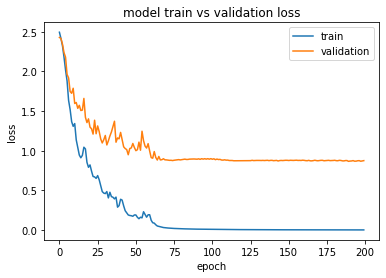

In [18]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.savefig("C:/ML/loss"f"{starttime}.png")
pyplot.show()

pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.savefig("C:/ML/accuracy_"f"{starttime}.png")
pyplot.show()

#### Underfit Example
Running this example produces a plot of train and validation loss showing the characteristic of an underfit model. In this case, performance may be improved by increasing the number of training epochs.


<img src="assets/Diagnostic-Line-Plot-Showing-an-Underfit-Model.png" width="400">


Running this example shows the characteristic of an underfit model that appears under-provisioned.
In this case, performance may be improved by increasing the capacity of the model, such as the number of memory cells in a hidden layer or number of hidden layers.

<img src="assets/Diagnostic-Line-Plot-Showing-an-Underfit-Model-via-Status.png" width="400">

#### Good Fit Example
Running the example creates a line plot showing the train and validation loss meeting.
Ideally, we would like to see model performance like this if possible, although this may not be possible on challenging problems with a lot of data.

<img src="assets/Diagnostic-Line-Plot-Showing-a-Good-Fit-for-a-Model.png" width="400">

#### Overfit Example
Running this example creates a plot showing the characteristic inflection point in validation loss of an overfit model.
This may be a sign of too many training epochs.
In this case, the model training could be stopped at the inflection point. Alternately, the number of training examples could be increased.

<img src="assets/Diagnostic-Line-Plot-Showing-an-Overfit-Model.png" width="400">

### Evaluate

In [ ]:
#model = tf.keras.models.load_model('./tmp/epoch49-0.90-0.39.hdf5')


#bestmodel.evaluate(x=x_test, y=y_test, verbose=2)
model.evaluate(x=x_test, y=y_test, verbose=2)


### Save model

In [ ]:
bestmodel.save("sign_lang_recognition_tuned.h5")